# Transit On the SHN 
* [GH Issue](https://github.com/cal-itp/data-analyses/issues/1477)


In [ ]:
import geopandas as gpd
import google.auth
import numpy as np
import pandas as pd

credentials, project = google.auth.default()

import gcsfs

fs = gcsfs.GCSFileSystem()

In [ ]:


from calitp_data_analysis import geography_utils, utils
from segment_speed_utils import gtfs_schedule_wrangling, helpers
from shared_utils import (
    catalog_utils,
    dask_utils,
    gtfs_utils_v2,
    portfolio_utils,
    publish_utils,
    rt_dates,
    rt_utils,
)
from update_vars import GTFS_DATA_DICT, RT_SCHED_GCS, SCHED_GCS, SEGMENT_GCS



In [ ]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

In [ ]:
analysis_date_list = rt_dates.y2024_dates + rt_dates.y2023_dates + rt_dates.y2025_dates

In [ ]:
analysis_date = "2025-03-12"

In [ ]:
def process_transit_routes() -> gpd.GeoDataFrame:
    """
    Select the most recent transit route.
    Also count how many routes there are for each operator.
    """
    OPERATOR_ROUTE = GTFS_DATA_DICT.digest_tables.operator_routes_map

    subset = [
        "service_date",
        "geometry",
        "portfolio_organization_name",
        "recent_combined_name",
        "schedule_gtfs_dataset_key",
    ]
    op_geography_df = gpd.read_parquet(
        f"{RT_SCHED_GCS}{OPERATOR_ROUTE}.parquet",
        storage_options={"token": credentials.token},
    )[subset]

    most_recent_routes = publish_utils.filter_to_recent_date(
        df=op_geography_df,
        group_cols=[
            "portfolio_organization_name",
        ],
    )

    # Calc length of route
    most_recent_routes = most_recent_routes.assign(
        route_length_feet=most_recent_routes.geometry.to_crs(
            geography_utils.CA_NAD83Albers_ft
        ).length
    )

    # Drop duplicates
    most_recent_routes = most_recent_routes.drop_duplicates(
        subset=["portfolio_organization_name", "recent_combined_name", "service_date"]
    )
    return most_recent_routes

In [ ]:
# transit_routes.drop(columns=["geometry"]).sample(3)

## Load in SHS 
* Saving it out isn't working

In [ ]:
def dissolve_shn() -> gpd.GeoDataFrame:
    """
    Dissolve State Highway Network so
    there will only be one row for each
    route name and route type
    """
    # calitp-analytics-data/data-analyses/state_highway_network
    SHN_FILE = catalog_utils.get_catalog(
        "shared_data_catalog"
    ).state_highway_network.urlpath

    shn = gpd.read_parquet(
        SHN_FILE,
        storage_options={"token": credentials.token},
    ).to_crs(geography_utils.CA_NAD83Albers_ft)

    # Dissolve
    shn_dissolved = (
        shn.dissolve(by=["Route"])
        .reset_index()
        .drop(columns=["County", "District", "Direction", "RouteType"])
    )

    shn_dissolved = shn_dissolved.rename(columns={"Route": "shn_route"})

    shn_dissolved = shn_dissolved.assign(
        highway_feet=shn_dissolved.geometry.length,
        shn_route=shn_dissolved.shn_route.astype(int),
    )

    shn_dissolved.to_parquet(
        "gs://calitp-analytics-data/data-analyses/state_highway_network/shn_dissolved.parquet",
        filesystem=fs,
    )
    return shn_dissolved

In [ ]:
# dissolved = dissolve_shn()

In [ ]:
# shn_dissolved.loc[shn_dissolved.shn_route == 210].drop(columns=["geometry"])

In [ ]:
# shn_dissolved.loc[shn_dissolved.shn_route == 110].drop(columns=["geometry"])

In [ ]:
# shn_dissolved.loc[shn_dissolved.Route == 210].explore()

In [ ]:
# shn_dissolved.loc[shn_dissolved.Route == 110].explore()

In [ ]:
# len(shn_dissolved)

In [ ]:
def buffer_shn(buffer_amount: int) -> gpd.GeoDataFrame:
    """
    Add a buffer to the SHN file. Save it out so
    we won't have to buffer over and over again.
    """
    GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/state_highway_network/"

    shn_df = gpd.read_parquet(
        f"{GCS_FILE_PATH}shn_dissolved.parquet",
        storage_options={"token": credentials.token},
    )

    shn_df_buffered = shn_df.assign(
        geometry=shn_df.geometry.buffer(buffer_amount),
    )

    shn_df_buffered.to_parquet(
        f"{GCS_FILE_PATH}shn_buffered_{buffer_amount}_ft.parquet", 
        filesystem=fs
    )

    return shn_df_buffered

In [ ]:
SHN_HWY_BUFFER_FEET = 50
PARALLEL_HWY_BUFFER_FEET = geography_utils.FEET_PER_MI * 0.5

In [ ]:
# intersecting_buffer.shape

In [ ]:
# buffered_df = buffer_shn(SHN_HWY_BUFFER_FEET)

In [ ]:
# buffered_df.columns

## Overlay

In [ ]:
def routes_shn_intersection(
    buffer_amount: int,
) -> gpd.GeoDataFrame:

    GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/state_highway_network/"

    # Read in buffered shn here or re buffer
    HWY_FILE = f"{GCS_FILE_PATH}shn_buffered_{buffer_amount}_ft.parquet"

    if fs.exists(HWY_FILE):
        shn_routes_gdf = gpd.read_parquet(
            HWY_FILE, storage_options={"token": credentials.token}
        )
    else:
        shn_routes_gdf = buffer_shn(buffer_amount)

    # Process the most recent transit route geogrpahies
    transit_routes_gdf = process_transit_routes().to_crs(shn_routes_gdf.crs)

    # Overlay
    gdf = gpd.overlay(
        transit_routes_gdf, shn_routes_gdf, how="intersection", keep_geom_type=True
    )

    # Calcuate the percent of the transit route that runs on a highway
    gdf = gdf.assign(
        pct_route_on_hwy=(gdf.geometry.length / gdf.route_length_feet).round(3) * 100,
        shn_route=gdf.shn_route.astype(int),
    ).drop(
        columns=[
            "geometry",
        ]
    )

    # Join back for geo and any routes that don't intersect with the SHS
    gdf2 = pd.merge(
        transit_routes_gdf,
        gdf,
        on=[
            "service_date",
            "portfolio_organization_name",
            "recent_combined_name",
            "schedule_gtfs_dataset_key",
            "route_length_feet",
        ],
        how="left",
    )

    return gdf2

In [ ]:
intersecting = routes_shn_intersection(SHN_HWY_BUFFER_FEET)

In [ ]:
intersecting.pct_route_on_hwy.describe()

In [ ]:
# transit_routes_gdf = process_transit_routes()

In [ ]:
# len(intersecting)

In [ ]:
# intersecting.loc[intersecting.pct_route_on_hwy != 0].recent_combined_name.nunique()

## Create final dataframes

In [ ]:
def prep_transit_route_shs(gdf: gpd.GeoDataFrame, pct_route_intersection: int):
    # Aggregate to find the total pct of a transit route because
    # a route can intersect with one or more state highway
    # so there will only be one row for one transit route instead of
    # many rows for one transit route.
    map_gdf = (
        gdf.groupby(
            [
                "portfolio_organization_name",
                "recent_combined_name",
                "schedule_gtfs_dataset_key",
            ]
        )
        .agg({"pct_route_on_hwy": "sum"})
        .reset_index()
    )

    # Filter out for any pct_route_on_hwy that we deem too low. 
    map_gdf = map_gdf.loc[map_gdf.pct_route_on_hwy > pct_route_intersection]
    
    # Join back to get the original transit route geometries.
    map_gdf2 = pd.merge(
        gdf[
            ["schedule_gtfs_dataset_key", "recent_combined_name", "geometry"]
        ].drop_duplicates(),
        map_gdf,
        on=["schedule_gtfs_dataset_key", "recent_combined_name"],
    )
    # We want a text table to display.
    # For transit routes that intersect with multiple highways, join the highways
    # together so there will be one row for a unique route.
    
    text_df = pd.merge(
        gdf.drop(columns=["pct_route_on_hwy"]), map_gdf2.drop(columns = ["geometry"]), how="inner"
    )
    text_df = (
        (
            text_df.groupby(
                [
                    "portfolio_organization_name",
                    "recent_combined_name",
                    "schedule_gtfs_dataset_key",
                    "pct_route_on_hwy",
                ],
                as_index=False,
            )
        )["shn_route"]
        .agg(lambda x: ", ".join(set(x.astype(str))))
        .reset_index(drop=True)
    )

    return map_gdf2, text_df

In [ ]:
map_gdf, text_df = prep_transit_route_shs(intersecting, 20)

In [ ]:
len(map_gdf)

In [ ]:
GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/state_highway_network/"

# Read in buffered shn here or re buffer
HWY_FILE = f"{GCS_FILE_PATH}shn_buffered_{SHN_HWY_BUFFER_FEET}_ft.parquet"

In [ ]:
shn_gdf = gpd.read_parquet(HWY_FILE, storage_options={"token": credentials.token})

In [ ]:
len(shn_gdf)

In [ ]:
shn_gdf2 = shn_gdf.dissolve()

In [ ]:
len(shn_gdf2)

In [ ]:
m = shn_gdf2.explore(height=250, width=500, name="shs")

In [ ]:
m

In [ ]:
m = map_gdf.explore("recent_combined_name", m=m, name="transit_routes")

In [ ]:
# m

In [ ]:
""" map_gdf.explore(
    "recent_combined_name",
    tiles="CartoDB positron",
    width=1000,
    height=600,
    style_kwds={"weight": 3},
    legend=False,
)"""

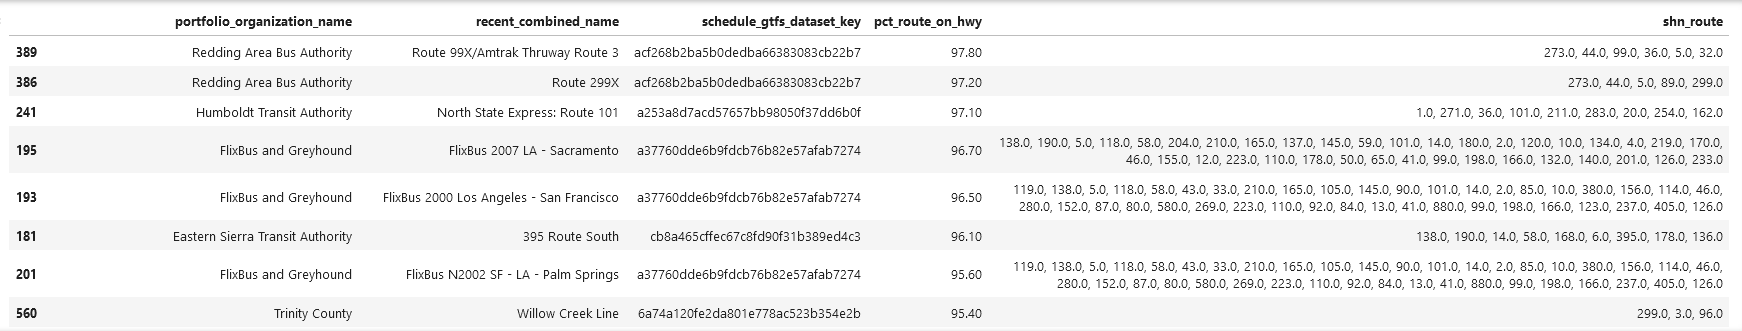

In [ ]:
text_df.sort_values(by = ["pct_route_on_hwy"], ascending = False)